<a href="https://colab.research.google.com/github/FFI-Vietnam/camtrap-tools/blob/main/04_create-decision-tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This script evaluates recall accuracy of MegaDetector from a ground-truth dataset
and a result json file. Then it creates a set of visualization of recall values 
on each group of species.

After runnning this script, a 'results' folder is created

results
    |__ 
    
"""

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import os
from tqdm.notebook import tqdm

from sklearn import tree
import graphviz 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# specifies Colab directories and file names
root = '/content/drive/'

dataset_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/dataset'
contain_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/data cleaning'
image_folder = 'My Drive/FFI/MegaDetector Test/confusion-matrix/visualization'

ground_truth_file_name = '01_ground-truth-table_Kon-Plong.csv'
taxon_match_table_file_name = '02_taxon-database-with-conservation-status.csv'
confusion_matrix_file_name = '03_confusion-matrix.csv'

In [4]:
# read and save file functions
def read_csv_Google_drive(root, contain_folder, file_name):
  file_path = os.path.join(root, contain_folder, file_name)
  return pd.read_csv(file_path)

def save_csv_Google_drive(df, root, contain_folder, file_name, index=False):
  """
  function to save a csv file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'image_metadata(2020-06-26)_full.csv'
  """
  # save file to Colab runtime storage (will be deleted when this notebook is closed)
  df.to_csv('dataframe.csv', index=index)

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  with open('dataframe.csv', 'r') as f:
    df_file = f.read()

  with open(file_path, 'w') as f:
    f.write(df_file)

  print(f'File is saved to {file_name} in Google Drive at {file_path}')

def save_image_Google_drive(plt, root, contain_folder, file_name):
  """
  function to save an image file to Google Drive
  param examples:
    root = '/content/drive/'
    contain_folder = 'My Drive/FFI/dataset'
    file_name = 'MD_recall_all-species.jpg'
  """

  # save file back to Google Drive for permanent storage
  folder_path = os.path.join(root, contain_folder)
  file_path = os.path.join(root, contain_folder, file_name)
  try:
    os.makedirs(folder_path)
  except:
    pass

  plt.savefig(file_path)
  
  print(f'File is saved to {file_name} in Google Drive at {file_path}')

In [11]:
taxon_match_table = read_csv_Google_drive(root, contain_folder, taxon_match_table_file_name)
taxon_match_table

,id,class,order,family,genus,species,authority,commonNameEnglish,taxonomyType,uniqueIdentifier,FFI_species_name,conservation_status
0,2002045,Mammalia,Primates,Hominidae,Homo,sapiens,"Linnaeus, 1758",Human,biological,990ae9dd-7a59-4344-afcb-1b7b21368000,Human,Least Concern
1,2002596,Mammalia,Carnivora,Mustelidae,Martes,flavigula,"Boddaert, 1785",Yellow-throated Marten,biological,8d7dc39f-0fea-42fd-bc07-e95fde4bab06,Yellow-throated Marten,Least Concern
2,2012904,Aves,Passeriformes,Corvidae,Cissa,hypoleuca,"Salvadori & Giglioli, 1885",Indochinese Green Magpie,biological,d12f88ab-d7ce-4740-b111-5af70c352b63,Yellow-breasted Magpie,Least Concern
3,2021113,Aves,NaN,NaN,NaN,NaN,NaN,Bird,biological,b1352069-a39c-4a84-a949-60044271c0c1,Bird,Not Applicable
4,2003794,Mammalia,Carnivora,Viverridae,Paguma,larvata,"C.E.H. Smith, 1827",Masked Palm Civet,biological,05a177f4-8da4-400f-ad72-0a8437a1eea6,Masked Palm Civet,Least Concern
...,...,...,...,...,...,...,...,...,...,...,...,...
132,2015400,Aves,Passeriformes,Muscicapidae,Ficedula,hyperythra,"Blyth, 1843",NaN,biological,fd99749f-e5fd-4a8b-8787-823cfedb8c48,Snowy-browed Flycatcher,Least Concern
133,2004518,Mammalia,Primates,Cercopithecidae,Pygathrix,cinerea,"Nadler, 1997",Grey-shanked Douc Langur,biological,60ea9d1f-5448-4ec6-ba03-550db94e54e0,Grey-shanked Douc Langur,Critically Endangered
134,2015334,Aves,Passeriformes,Muscicapidae,Calliope,calliope,"Pallas, 1776",Siberian Rubythroat,biological,5880c476-0e8f-41c1-84b5-af860dfadcce,Siberian Rubythroat,Least Concern
135,2015253,Aves,Passeriformes,Muscicapidae,Cyornis,tickelliae,"Blyth, 1843",Tickell's Blue-Flycatcher,biological,144bac52-6be0-46ba-9b2d-7f6a67acf5b5,Tickell's Blue Flycatcher,Least Concern


In [31]:
dat = read_csv_Google_drive(root, contain_folder, confusion_matrix_file_name)

# unspecified species
unspecified_species = ['Banded Krait', 
                       'Black-throated Laughingthrush',
                       'Impressed Tortoise',
                       'Small Asian Mongoose',
                       'All']


# change and drop columns
dat['FFI_species_name'] = dat['Unnamed: 0']
dat = dat[['FFI_species_name', 'Recall']]

# drop rows
dat = dat[~ dat['FFI_species_name'].isin(unspecified_species)]

# get labels
labs = dat['Recall']
labs = labs>0.7

# add conservation status
conservation_status = []
for species in dat['FFI_species_name']:
  conservation_status.append(taxon_match_table[taxon_match_table['FFI_species_name'] == species]['conservation_status'].iat[0])
dat['conservation_status'] = conservation_status

# add class
taxon_class = []
for species in dat['FFI_species_name']:
  taxon_class.append(taxon_match_table[taxon_match_table['FFI_species_name'] == species]['class'].iat[0])
dat['class'] = taxon_class

# add order
taxon_order = []
for species in dat['FFI_species_name']:
  taxon_order.append(taxon_match_table[taxon_match_table['FFI_species_name'] == species]['order'].iat[0])
dat['order'] = taxon_order

# fill na
dat.fillna(value={'order':'Hello'}, inplace=True)

# drop columns
dat.drop(columns=['FFI_species_name', 'Recall'], inplace=True)

# get dummies
dat = pd.get_dummies(dat, columns=['conservation_status', 'class', 'order'])

dat

,conservation_status_Critically Endangered,conservation_status_Data Deficient,conservation_status_Endangered,conservation_status_Least Concern,conservation_status_Near Threatened,conservation_status_Not Applicable,conservation_status_Vulnerable,class_Aves,class_Mammalia,class_Reptilia,order_Accipitriformes,order_Artiodactyla,order_Carnivora,order_Cetartiodactyla,order_Charadriiformes,order_Columbiformes,order_Cuculiformes,order_Eulipotyphla,order_Galliformes,order_Gruiformes,order_Hello,order_Passeriformes,order_Pelecaniformes,order_Pholidota,order_Piciformes,order_Primates,order_Rodentia,order_Scandentia,order_Squamata,order_Strigiformes
0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
128,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
130,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [32]:
# create model
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 3)	
clf = clf.fit(dat, labs)

In [52]:
# calculate accuracy
correct = 0						
for i in range(len(dat)):	
    if clf.predict([dat.iloc[i]]) == labs.iloc[i]: 
      correct = correct + 1
100.0* correct / len(dat)

62.5

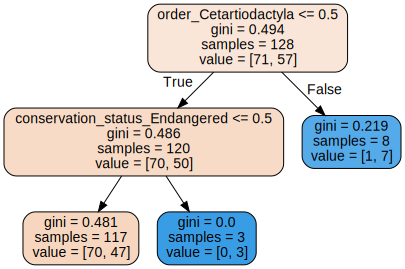

In [35]:
# visualize decision tree
dot_data = tree.export_graphviz(clf, feature_names=dat.columns,
                      filled=True, rounded=True) 
graph = graphviz.Source(dot_data)	
graph	